# Final Project - Jiayu Kang

For this project, I will use Corpus of Amazon movie reviews from 1999 to 2012 (https://snap.stanford.edu/data/web-Movies.html) to analyze the trends and language patterns of movie reviews. For computationally intensive tasks, I will use a random sample of 10,000 reviews from this corpus instead.

The project will mainly use techniques from week 3 (topic modeling), week 4 (word embeddings), week 6 (prediction and causal inference), and week 8 (text generation).

In [3]:
pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

  Cloning git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to /private/var/folders/22/wx3p99j10rn7qqczc3jwz7w80000gn/T/pip-req-build-_ljqgpit
  Running command git clone -q git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git /private/var/folders/22/wx3p99j10rn7qqczc3jwz7w80000gn/T/pip-req-build-_ljqgpit
  fatal: remote error:
    The unauthenticated git protocol on port 9418 is no longer supported.
  Please see https://github.blog/2021-09-01-improving-git-protocol-security-github/ for more information.
ERROR: Command errored out with exit status 128: git clone -q git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git /private/var/folders/22/wx3p99j10rn7qqczc3jwz7w80000gn/T/pip-req-build-_ljqgpit Check the logs for full command output.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install transformers

     |████████████████████████████████| 3.8 MB 2.8 MB/s 
     |████████████████████████████████| 895 kB 43.3 MB/s 
     |████████████████████████████████| 6.5 MB 66.7 MB/s 
     |████████████████████████████████| 67 kB 4.9 MB/s 
     |████████████████████████████████| 596 kB 34.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas as pd #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

import os #For looking through files
import os.path #For managing file paths
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.preprocessing.sequence import pad_sequences

# statsmodels is a popular Python statistics package
import statsmodels.api as sm
# Let's also import its graphics module
import statsmodels.graphics.api as smg
# And the mediation module
from statsmodels.stats.mediation import Mediation

# Pipelines to add text-based quantiative variables for regressions
from transformers import pipeline

# We have a lot of features, so let's set Pandas to show all of them.
pd.set_option('display.max_columns', None)

import torch # pip install torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig # pip install tranformers
from transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange

ModuleNotFoundError: No module named 'lucem_illud'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Loading and cleaning the corpus

In [ ]:
from datetime import datetime

In [ ]:
df = {'productId' : [], 'userId' : [], 'score' : [], 'helpfulness' : [], 'year' : [], 'text' : []}
for line in open('/Users/jiayukang/SOCI40133 Final Project/movies.txt','r', encoding='utf-8',
                 errors='ignore'):
    line = line.replace('\n', '')
    if 'product/productId:' in line: 
        info = line.replace('product/productId: ', '')
        df['productId'].append(info)
    elif 'review/userId:' in line: 
        info = line.replace('review/userId: ', '')
        df['userId'].append(info)
    elif 'review/score:' in line: 
        info = line.replace('review/score: ', '')
        df['score'].append(info)
    elif 'review/helpfulness:' in line: 
        info = line.replace('review/helpfulness: ', '')
        if info.split('/')[1] != '0':
            helpfulness = int(info.split('/')[0])/int(info.split('/')[1])
        if info.split('/')[1] == '0':
            helpfulness = 'N/A'          
        df['helpfulness'].append(helpfulness)
    elif 'review/time:' in line: 
        info = line.replace('review/time: ', '')
        year = datetime.utcfromtimestamp(int(info)).strftime('%Y')
        df['year'].append(year)
    elif 'review/text:' in line: 
        info = line.replace('review/text: ', '')
        clean = info.replace('<br /><br />', ' ')
        clean = info.replace('<br />', ' ')
        df['text'].append(clean)
df = pd.DataFrame.from_dict(df)
df.to_csv('/Users/jiayukang/SOCI40133 Final Project/moviereview.csv')

# Exploratory Analysis

First, I would like to explore this corpus using topic modeling and word embedding: what are the most frequent words mentioned in those reviews? How are the words similar in meaning? How is that different by helpful/unhelpful reviews?

In [ ]:
df = pd.read_csv('/Users/jiayukang/SOCI40133 Final Project/moviereview.csv')

In [ ]:
sample = df.sample(n = 10000)

In [ ]:
df["tokenized text"] = df["text"].apply(lambda x: lucem_illud.word_tokenize(x))
df["normalized tokens"] = df["tokenized text"].apply(lambda x: lucem_illud.normalizeTokens(x))
df['tokenized sents'] = df['text'].apply(lambda x: [lucem_illud.word_tokenize(sent) for sent in lucem_illud.sent_tokenize(x)])
df['normalized sents'] = df['tokenized sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, lemma=False) for s in x])

In [ ]:
moviereviewTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
moviereviewTFVectorizer.fit_transform(df['text'])

def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

df['reduced tokens'] = df['normalized tokens'].apply(lambda x: dropMissing(x, moviereviewTFVectorizer.vocabulary_.keys()))

In [ ]:
df.to_pickle('/Users/jiayukang/SOCI40133 Final Project/moviereview.df')

In [ ]:
df

,Unnamed: 0,productId,userId,score,helpfulness,year,text
0,0,B003AI2VGA,A141HP4LYPWMSR,3.0,1.000000,2007,"Synopsis: On the daily trek from Juarez, Mexic..."
1,1,B003AI2VGA,A328S9RN3U5M68,3.0,1.000000,2007,THE VIRGIN OF JUAREZ is based on true events s...
2,2,B003AI2VGA,A1I7QGUDP043DG,5.0,0.800000,2006,The scenes in this film can be very disquietin...
3,3,B003AI2VGA,A1M5405JH9THP9,3.0,1.000000,2007,THE VIRGIN OF JUAREZ (2006) directed by Kevin ...
4,4,B003AI2VGA,ATXL536YX71TR,3.0,1.000000,2007,"Informationally, this SHOWTIME original is ess..."
...,...,...,...,...,...,...,...
7911679,7911679,B003A3PGF8,A11H5P3Z6WGN8G,3.0,0.500000,2010,I was a little disappointed in Lisa Lampannell...
7911680,7911680,B003A3PGF8,A7QMQBGJ2TCQG,5.0,0.000000,2009,"Lisa Lampanelli is crude, cusses like a sailor..."
7911681,7911681,6304952198,AT0A56QQS6PKO,2.0,1.000000,2007,"As a listener to C2C, I was excited about this..."
7911682,7911682,6304952198,A23KKLV2CD39U8,4.0,NaN,2010,"This was a very interesting dvd, but the let d..."


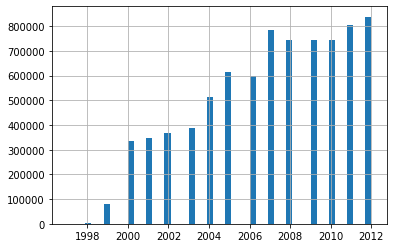

In [ ]:
df['year'].hist(bins=50)

In [ ]:
helpful = df.loc[(df['helpfulness'] > 0.5)]

In [ ]:
unhelpful = df.loc[(df['helpfulness'] <= 0.5)]

## Flat Clustering with $K$-means

In [ ]:
moviereviewCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
moviereviewVects = moviereviewCountVectorizer.fit_transform(df['text'])

In [ ]:
moviereviewTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(moviereviewVects)
moviereviewTF = moviereviewTFTransformer.transform(moviereviewVects)

In [ ]:
moviereviewTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
moviereviewTFVects = moviereviewTFVectorizer.fit_transform(df['text'])

In [ ]:
numClusters = 10
kmean = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')
kmean.fit(moviereviewTFVects)

KMeans(n_clusters=10)

I tried 10 clusters first for an initial analysis. The Silhouette analysis below will tell the optimal number of clusters.

In [ ]:
terms = moviereviewTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = kmean.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 www
 http
 com
 href
 gp
 product
 amazon
 film
 edition
 like


Cluster 1:
 blu
 ray
 dvd
 quality
 great
 version
 sound
 buy
 hd
 film


Cluster 2:
 great
 story
 love
 movies
 watch
 best
 time
 really
 just
 like


Cluster 3:
 dvd
 version
 vhs
 great
 buy
 time
 just
 quality
 bought
 love


Cluster 4:
 love
 watch
 movies
 time
 best
 just
 funny
 watched
 video
 seen


Cluster 5:
 quot
 film
 like
 great
 good
 best
 dvd
 just
 story
 time


Cluster 6:
 film
 films
 like
 story
 just
 time
 really
 good
 great
 best


Cluster 7:
 good
 movies
 like
 story
 really
 just
 acting
 bad
 watch
 pretty


Cluster 8:
 like
 just
 story
 film
 people
 time
 really
 life
 character
 don


Cluster 9:
 season
 episodes
 seasons
 episode
 series
 wait
 dvd
 great
 tv
 just




Looks like we already have some meaningful clutering! For instance, there seems to be clear clusters on the product (i.e. sound, format, version), content (i.e. story, acting, character), and sentiments (e.g. love/like, good/great).

In [ ]:
pca = sklearn.decomposition.PCA(n_components = 2).fit(moviereviewTFVects.toarray())
reduced_data = pca.transform(moviereviewTFVects.toarray())

colors = list(plt.cm.rainbow(np.linspace(0,1, numClusters)))
colors_p = [colors[l] for l in kmean.labels_]

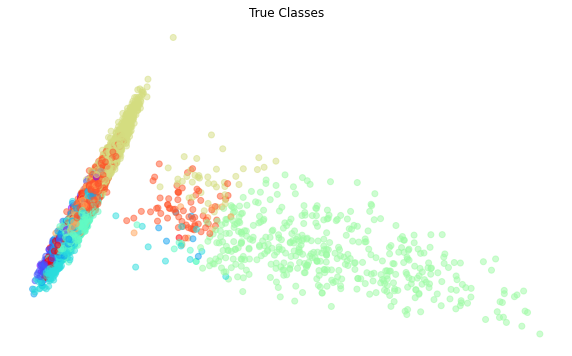

In [ ]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

In [ ]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


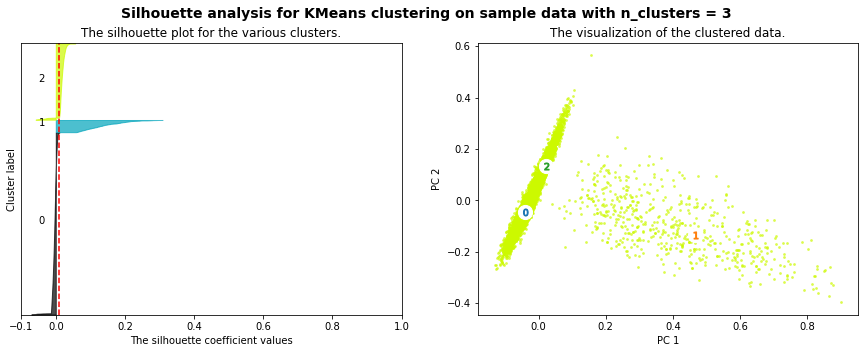

For n_clusters = 3, The average silhouette_score is : 0.008


In [ ]:
X = moviereviewTFVects.toarray()
plotSilhouette(3, X)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


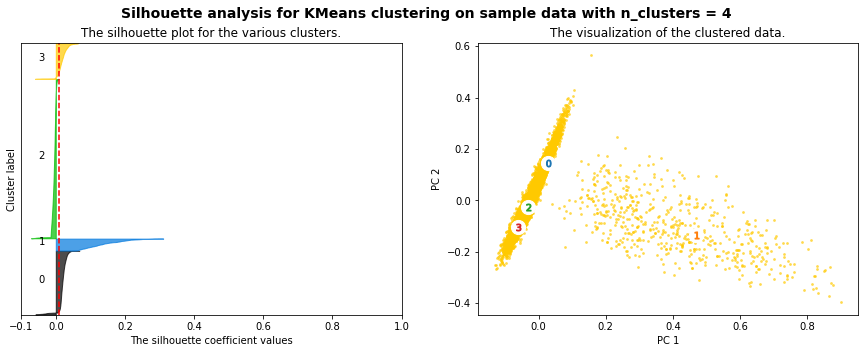

For n_clusters = 4, The average silhouette_score is : 0.010


In [ ]:
X = moviereviewTFVects.toarray()
plotSilhouette(4, X)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


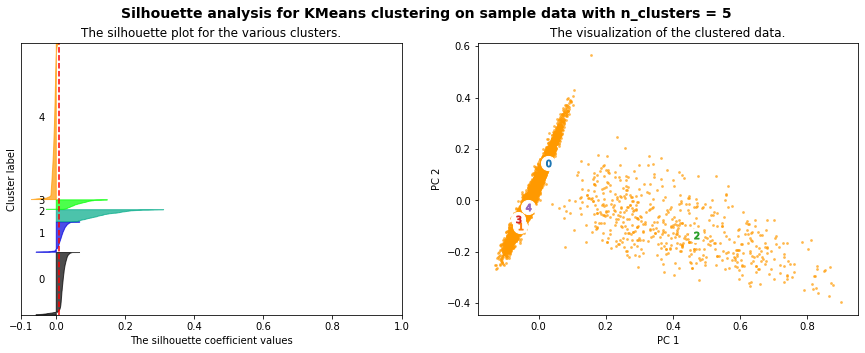

For n_clusters = 5, The average silhouette_score is : 0.011


In [ ]:
X = moviereviewTFVects.toarray()
plotSilhouette(5, X)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


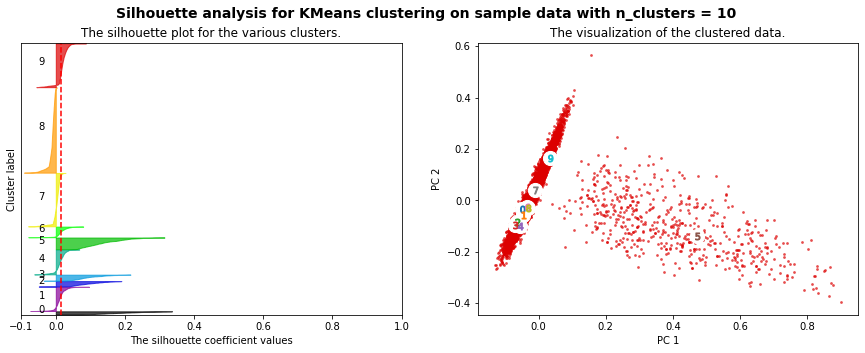

For n_clusters = 10, The average silhouette_score is : 0.015


In [ ]:
X = moviereviewTFVects.toarray()
plotSilhouette(10, X)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


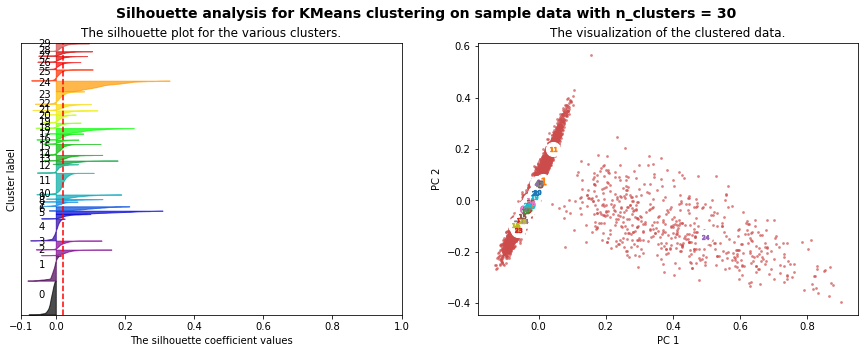

For n_clusters = 30, The average silhouette_score is : 0.021


In [ ]:
X = moviereviewTFVects.toarray()
plotSilhouette(30, X)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


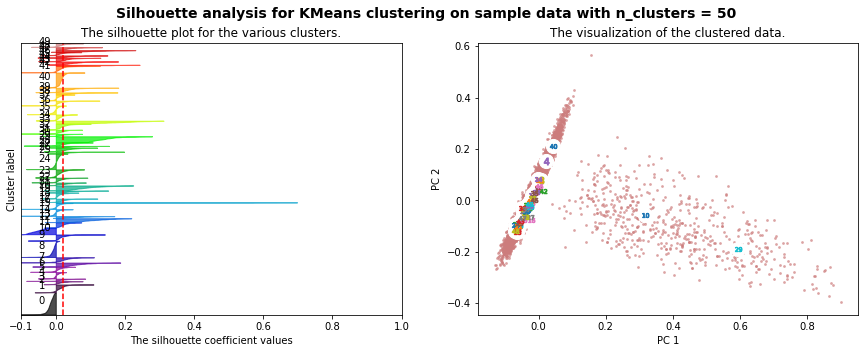

For n_clusters = 50, The average silhouette_score is : 0.019


In [ ]:
X = moviereviewTFVects.toarray()
plotSilhouette(50, X)

Cluster number = around 30 works better, but the silhouette score is still low, and the visualization shows that the clustering is not that meaningful.

##Topic Models

In [ ]:
dictionary = gensim.corpora.Dictionary(df['reduced tokens'])

In [ ]:
corpus = [dictionary.doc2bow(text) for text in df['reduced tokens']]

In [ ]:
gensim.corpora.MmCorpus.serialize('moviereview.mm', corpus)
moviemm = gensim.corpora.MmCorpus('moviereview.mm')

In [ ]:
moviereviewlda = gensim.models.ldamodel.LdaModel(corpus=moviemm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [ ]:
moviereview1Bow = dictionary.doc2bow(df['reduced tokens'][0])
moviereview1lda = moviereviewlda[moviereview1Bow]
print("The topics of the text: {}".format(df['reduced tokens'][0]))
print("are: {}".format(moviereview1lda))

In [ ]:
moviereviewldaDF = pd.DataFrame({
        'Unnamed: 0' : df['Unnamed: 0'],
        'topics' : [moviereviewlda[dictionary.doc2bow(l)] for l in df['reduced tokens']]
    })

In [ ]:
topicsProbDict = {i : [0] * len(moviereviewldaDF) for i in range(moviereviewlda.num_topics)}

In [ ]:
for index, topicTuples in enumerate(moviereviewldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

In [ ]:
for topicNum in range(moviereviewlda.num_topics):
    moviereviewldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

In [ ]:
moviereviewldaDF

,Unnamed: 0,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,4680275,"[(4, 0.26527843), (6, 0.7149349)]",0.000000,0.000000,0.000000,0.000000,0.265278,0.000000,0.714935,0.000000,0.000000,0.000000
1,250911,"[(7, 0.97935677)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.979357,0.000000,0.000000
2,2077981,"[(3, 0.60134554), (6, 0.38175958)]",0.000000,0.000000,0.000000,0.601346,0.000000,0.000000,0.381760,0.000000,0.000000,0.000000
3,6978438,"[(2, 0.54047626), (4, 0.43596563)]",0.000000,0.000000,0.540476,0.000000,0.435966,0.000000,0.000000,0.000000,0.000000,0.000000
4,1442375,"[(1, 0.182977), (2, 0.10312152), (3, 0.7050987)]",0.000000,0.182977,0.103122,0.705099,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,451835,"[(0, 0.015926555), (1, 0.016023926), (2, 0.013...",0.015927,0.016024,0.013754,0.862787,0.017441,0.013804,0.016738,0.015885,0.015147,0.012494
9996,7474136,"[(8, 0.8808232), (9, 0.11520015)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.880823,0.115200
9997,4900613,"[(5, 0.9548643)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.954864,0.000000,0.000000,0.000000,0.000000
9998,49933,"[(4, 0.9258145)]",0.000000,0.000000,0.000000,0.000000,0.925815,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
moviereviewldaDFV = moviereviewldaDF[-10:][['topic_%d' %x for x in range(10)]]
moviereviewldaDFVisN = moviereviewldaDF[-10:][['Unnamed: 0']]
moviereviewldaDFVis = moviereviewldaDFV.values
moviereviewldaDFVisNames = moviereviewldaDFVisN.values
moviereviewldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
9990,0.000000,0.697798,0.000000,0.000000,0.000000,0.000000,0.281460,0.000000,0.000000,0.000000
9991,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.965245,0.000000,0.000000,0.000000
9992,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.948863,0.000000,0.000000,0.000000
9993,0.000000,0.000000,0.000000,0.723914,0.000000,0.000000,0.000000,0.245446,0.000000,0.000000
9994,0.000000,0.000000,0.013568,0.000000,0.000000,0.166126,0.000000,0.680254,0.000000,0.133277
9995,0.015927,0.016024,0.013754,0.862787,0.017441,0.013804,0.016738,0.015885,0.015147,0.012494
9996,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.880823,0.115200
9997,0.000000,0.000000,0.000000,0.000000,0.000000,0.954864,0.000000,0.000000,0.000000,0.000000
9998,0.000000,0.000000,0.000000,0.000000,0.925815,0.000000,0.000000,0.000000,0.000000,0.000000
9999,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.096366,0.897425,0.000000,0.000000


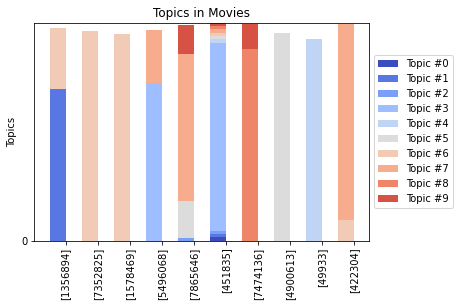

In [ ]:
N = 10
ind = np.arange(N)
K = moviereviewlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, moviereviewldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, moviereviewldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += moviereviewldaDFVis[:, k]
    plots.append(p)

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Movies')
plt.xticks(ind+width/2, moviereviewldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

In [ ]:
topicsDict = {}
for topicNum in range(moviereviewlda.num_topics):
    topicWords = [w for w, p in moviereviewlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

moviereviewwordRanksDF = pd.DataFrame(topicsDict)
moviereviewwordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,watch,dvd,film,film,like,horror,dvd,film,film,film
1,time,film,great,story,film,film,season,character,good,man
2,love,version,director,book,good,like,love,life,star,performance
3,story,time,feature,great,look,end,watch,people,like,great
4,like,original,story,character,watch,time,like,like,think,time
5,life,release,time,like,scene,great,episode,think,come,action
6,film,great,fan,scene,kid,good,great,story,fan,play
7,great,like,batman,series,think,act,buy,end,watch,good
8,good,buy,cast,love,know,play,time,good,scene,john
9,year,scene,actor,play,time,watch,good,man,great,cast


##Dynamic Topic Modeling
I'm using a smaller sample of 1000 reviews for this task.

In [ ]:
sample = df.sample(n=1000)

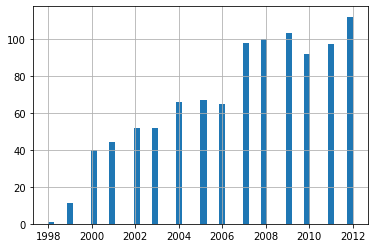

In [ ]:
sample['year'].hist(bins=50)

In [ ]:
docs_per_time_slice = np.flip(sample['year'].value_counts().to_numpy())

In [ ]:
from gensim.models import ldaseqmodel

In [ ]:
sampledictionary = gensim.corpora.Dictionary(sample['reduced tokens'])
samplecorpus = [sampledictionary.doc2bow(text) for text in sample['reduced tokens']]
gensim.corpora.MmCorpus.serialize('sample.mm', samplecorpus)
corpus = gensim.corpora.MmCorpus('sample.mm')

In [ ]:
ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=docs_per_time_slice, num_topics=3)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldaseqmodel.py:290: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


In [ ]:
ldaseq.print_topics(time=0)[0]

[('amp', 0.03138850322543299),
 ('people', 0.02562556299673956),
 ('recommend', 0.020166864284114266),
 ('brilliant', 0.019605040180190443),
 ('series', 0.01672636459977309),
 ('theme', 0.01664022696845703),
 ('experience', 0.014544581913976649),
 ('play', 0.013977540480397585),
 ('huge', 0.012304968406427195),
 ('peter', 0.011415925598354072),
 ('background', 0.009917352698354054),
 ('epic', 0.009713335453686616),
 ('book', 0.009325831644802914),
 ('extra', 0.008913811918586987),
 ('control', 0.007814615411129322),
 ('predictable', 0.0076898733148587604),
 ('point', 0.007439485349241854),
 ('child', 0.007332756382983344),
 ('score', 0.007255023577965945),
 ('addition', 0.007079230538809261)]

In [ ]:
topics = pd.DataFrame(columns=range(2000,2013))

for j in range(0,3):
    topics.loc[len(topics)] = [0] * 13
for i in range(2000,2012):
    for j in range(0,3):
        topics[i][j] = ldaseq.print_topics(time=(i-2000))[j]

In [ ]:
for topicNum in range(0,3):
    print(f'\nChanges in Topic {topicNum} Over Time')
    topicsDict = {}
    for year in range(2000,2013):
        topicWords = []
        for tup in topics[year][topicNum]:
            topicWords.append(tup[0])
        topicsDict[year] = topicWords
    wordRanksDF = pd.DataFrame(topicsDict)
    display(wordRanksDF)


Changes in Topic 0 Over Time


,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011
0,amp,amp,amp,amp,amp,amp,amp,amp,amp,amp,amp,amp
1,people,people,people,people,people,people,people,people,people,people,people,people
2,recommend,recommend,recommend,brilliant,brilliant,brilliant,brilliant,brilliant,brilliant,brilliant,brilliant,brilliant
3,brilliant,brilliant,brilliant,recommend,recommend,recommend,recommend,series,series,series,series,series
4,series,series,series,series,series,series,series,recommend,recommend,recommend,recommend,recommend
5,theme,theme,theme,theme,theme,theme,theme,experience,experience,play,play,play
6,experience,experience,experience,experience,experience,experience,experience,theme,theme,experience,theme,theme
7,play,play,play,play,play,play,play,play,play,theme,experience,experience
8,huge,huge,huge,huge,huge,huge,peter,peter,peter,peter,peter,peter
9,peter,peter,peter,peter,peter,peter,huge,huge,huge,epic,epic,epic



Changes in Topic 1 Over Time


,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011
0,late,late,late,late,late,late,late,late,late,late,late,late
1,series,series,series,series,series,series,series,series,series,series,series,series
2,brilliant,brilliant,brilliant,brilliant,brilliant,brilliant,brilliant,brilliant,brilliant,brilliant,brilliant,brilliant
3,play,play,play,recommend,recommend,recommend,recommend,recommend,recommend,recommend,recommend,recommend
4,recommend,recommend,recommend,play,play,play,hear,hear,hear,hear,hear,hear
5,hear,hear,hear,hear,hear,hear,romance,romance,day,day,day,day
6,day,day,day,day,romance,romance,play,day,romance,romance,romance,romance
7,romance,romance,romance,romance,day,day,day,play,play,play,play,play
8,extra,extra,extra,extra,extra,vampire,extra,vampire,vampire,wonderful,wonderful,wonderful
9,vampire,vampire,vampire,vampire,vampire,extra,vampire,extra,wonderful,vampire,vampire,vampire



Changes in Topic 2 Over Time


,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011
0,late,late,late,late,late,late,late,late,late,late,late,late
1,experience,experience,experience,experience,experience,experience,experience,experience,experience,experience,experience,experience
2,ray,ray,ray,ray,ray,ray,ray,series,series,series,series,series
3,fall,fall,fall,fall,fall,series,series,ray,ray,ray,ray,ray
4,day,day,day,day,series,fall,fall,fall,fall,fall,fall,power
5,series,series,series,series,day,day,day,day,day,day,power,fall
6,people,people,fact,fact,fact,fact,fact,fact,fact,fact,day,day
7,fact,fact,people,people,people,people,people,people,power,power,fact,fact
8,hear,hear,hear,hear,hear,hear,power,power,people,people,people,people
9,classic,classic,classic,power,power,power,hear,hear,hear,say,say,say


The topics are relatively consistent overtime.

## Word Embeddings

In [ ]:
W2V = gensim.models.word2vec.Word2Vec(df['normalized sents'].sum(), sg=0)

In [ ]:
targetWords = W2V.wv.index2word[:100]
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(W2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[ 0.72402626,  0.18454708,  0.1411103 , ..., -0.44272935,
        -0.04708518,  0.30868456],
       [ 0.3788475 ,  0.03621851, -0.16567174, ..., -0.56924427,
         0.3653134 ,  0.24339952],
       [ 0.04458129,  0.7834312 , -0.6535909 , ...,  0.12931474,
         0.18786006,  0.42856413],
       ...,
       [ 0.23210824,  0.6647297 , -0.70256996, ..., -0.13034758,
         0.4039945 ,  0.22151227],
       [-0.3601813 ,  0.3483158 , -0.30706173, ..., -0.4063198 ,
        -1.2730705 ,  0.10184225],
       [-0.17048357,  0.39581156, -0.49713168, ...,  0.02512269,
        -0.87870485,  0.27111724]], dtype=float32)

In [ ]:
numWords = 100

In [ ]:
pcaWords = sklearn.decomposition.PCA(n_components = numWords).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

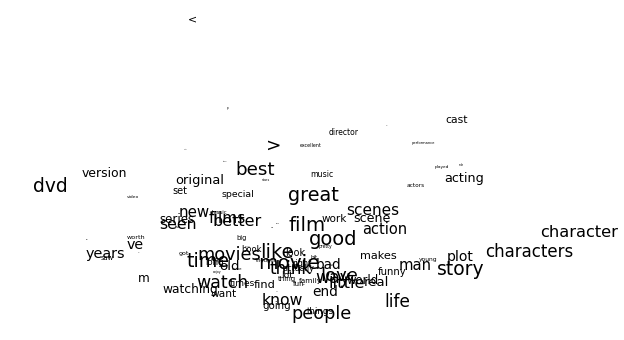

In [ ]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (reducedPCA_data[:, 0][i],reducedPCA_data[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

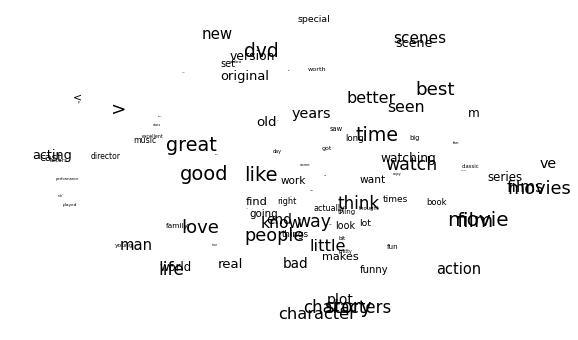

In [ ]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

Both PCA and T-SNE provided interesting information. It looks like T-SNE did a better job at visulizing some distinctive clusters: for example, "acting, director, and music" and "series, movies, and action" are at two ends; "plot and characters" and scenes are also far apart. Interestingly, in the graph produced using PCA, positive adjectives such as "good", "great", "best", and verbs such as "like", "love" are closer to "movies/film", "scenes", "action", "music". When using T-SNE, Those words are closer to "director", "music", "people", while the adjectives "real", "bad", and "funny" are closer to plot and characters.

Let's take a look at the sample (1000 reviews) to see the context where those words are used:

In [ ]:
Text = ' '.join(sample['text'].apply(str))
Tokens = lucem_illud.word_tokenize(Text)

In [ ]:
import nltk

In [ ]:
Text = nltk.Text(Tokens)

Index = nltk.text.ConcordanceIndex(Text) 
Index.print_concordance('character')

Displaying 25 of 165 matches:
ovide a measure of weight to his character It makes a difference from a pur
he Birds is a brilliantly staged character study one that delves into the f
ilding such a remarkably sincere character In the end ` The Birds will alwa
s to be the worst view of a real character Hollywood and especially John Wa
ething else and used a fictional character Chisum 's life is interesting en
 is Unfortunately she is a minor character and we only get to watch her son
ow that it was completely out of character His followup The Neverending Sto
addy Day Care&quot of making his character the perfect salesman father figu
 clear resolution to some of the character 's fate In fact only about 10 of
ten lack the passion of what the character is saying In one scene Sophie is
hool amateur acting way too many character stereotypes black guy is always 
ore than a jive talking sidekick character Spanaird guy is cocky and barbar
lm fight that did not end with a character being knocked o

In [ ]:
Index.print_concordance('plot')

Displaying 25 of 129 matches:
sters of Universal Studios But the plot is bad The dialogue is bad It is j
light of tigers I wo n't spoil the plot because many people have already g
 people have already gone over the plot but the stars of this movie are de
here The actors were great and the plot even better It should have came ou
r for evil Nothing of any depth in plot or performance save for Sean Conne
ds of the spectrum which makes the plot even more interesting Together the
u are out of your jurisdiction The plot was full of holes that the movie m
ecures a book from Koreander whose plot is in essence the rest of the film
lm and the sadness of parts of the plot But I will always rate this film v
 > Here 's a brief synopsis of the plot Murphy 's wife is called to quot;s
which he never did see himself The plot takes Gere to the Ohio West Virgin
eally rates 5 stars for its strong plot acting direction and camera work T
have slated this movie for lack of plot or over reliance of special ef

In [ ]:
Index.print_concordance('director')

Displaying 25 of 83 matches:
t Great job Well the writers and director finally got it right This X men 
ed himself out Oliver Parker the director certainly had so much more style
and he delivers In this film the director goes world wide documenting God 
 DVD has two extra features- the director 's vision for the movie and inte
V series with the dark vision of director Tim Burton and the black humour 
sume there is a longer version A director 's cut is hopefully be released 
e portrayal of the enigmatic boy director Co stars John Malkovich as Welle
re still alive would be amazed A director who seems so opposite in filmmak
 as soon as possible I read that director Jerry Aronson spent 25 years col
lly really good and I credit the director John Stockwell who is also known
wrote a biography on the Italian director I 'm a high school history teach
tras and a great commentary from director Clark God and baby Jesus help me
 lazy wooden performances If the director was any good he might have be

In [ ]:
Index.print_concordance('story')

Displaying 25 of 313 matches:
                                   story 2 you see the origin of woody this
warm hearted charming and romantic story I really loved some of the dresses
ver seen a more powerful film Good story good actors and great soundtrack I
and great soundtrack It 's a great story rather than 90 minutes of explosio
nd special effects A very charming story The beginning premise was good how
ooking the forest The moral of the story is excellent It shows the trouble 
n is one of the best in the Beaver story arc and I 'm greatly looking forwa
Stewart and Jackman are superb The story is exciting and although the final
hooting for no reason no script no story poorest acting ever make a movie D
eone that is looking to watch this story more than once and for anyone who 
d the books to be caught up in the story I for one was blown away by the CG
ke a Hoover Like a black hole True story In the late 1700s a boy who was ro
ly really stupid movie with a dumb story and weak acting J

In [ ]:
Index.print_concordance('scene')

Displaying 25 of 121 matches:
en you have a campfire bean eating scene where cowboys are passing gas in t
ich enjoys a fine independent film scene but I never saw a single one I was
 the movie is great There 's a new scene that is seamlessly integrated into
le dvd player and our PS3 and that scene skips every time even the first ti
s an actors actor Even the Goodbye scene for Shatner and Nimoy Spock was he
 for the small kids especially one scene in an old crypt where tons of badd
hat the character is saying In one scene Sophie is upbraiding Julien giving
 father Walter Connolly I love the scene where she tells Peter he can leave
da like prose I sum it up with one scene Our hero has a Black friend that h
and same hair cut as he did in the scene or on the day that the hero died T
Black friend However in a proximal scene the hero reunites with the Japanes
mention how hokey the final climax scene of this garbage is I really would 
Service agent Hackett in the fight scene between him and T

In [ ]:
Index.print_concordance('good')

Displaying 25 of 404 matches:
en a more powerful film Good story good actors and great soundtrack It 's 
ng story The beginning premise was good however the movie took a dramatic 
cently and found it to be a pretty good movie 12 year old audience oriente
d situations at their own work Not good for young kids due to some languag
o anyone else who is looking for a good laugh Val Kilmer and Michael Dougl
rama in this play is off the chain good The singing throughout this entire
edy in this play is also very very good This entire play is one that you h
ffects are electrifying There 's a good mix of comedy hope revelation and 
he best part of course is that the good guys and bad guys have to team up 
tional characters working here for good or for evil Nothing of any depth i
 queens This is an all around feel good movie Hope you enjoy it as much as
n't seen many westerns despite how good I think it is but if you want a di
is the one I picked out It was soo good I was n't expecting anything r

In [ ]:
Index.print_concordance('bad')

Displaying 25 of 122 matches:
 sure The action would n't look too bad for a bunch of 32 year old actors o
 few years ago I thought it was not bad but nothing all that special either
f Universal Studios But the plot is bad The dialogue is bad It is just not 
But the plot is bad The dialogue is bad It is just not funny There are no l
of course is that the good guys and bad guys have to team up to defeat the 
s very worried after I read so many bad revies that I even went out and bou
ay something like you 're kind of a bad guy As Sophie Marion Cotillard ligh
ore I shut it off It is filled with bad high school amateur acting way too 
e fervent about this being a really bad piece of Sci Fi entertainment The a
y at its best Once you get over the bad language(lots of it It is the best 
 do n't go their way Things go from bad to worse and in the end you will wo
 calling in life Taking care of the bad guys Basicly this moive have lots o
r can be a funny guy It 's just too bad he chooses to focu

In [ ]:
Index.print_concordance('like')

Displaying 25 of 481 matches:
nts Slow paced at times feels more like an Alaskan travelogue than a spy v
 since then though and each time I like it more Now I 'd describe it as a 
an set plus it has other countries like Malaysia Japan Thailand ect Hello 
ntary from historians and scholars like John Canemaker would have been pre
Decades cast the testimonials felt like the actors were still under contra
ething to see She played that part like a champion on wheels I do n't thin
 been too often disregarded If you like Pulp Fiction you 're sure to enjoy
es have been done before but NEVER like this Some 30-odd years later Mel B
owboys are passing gas in turn And like YF BS has so many outrageously fun
It really really really sucked Not like a Hoover Like a black hole True st
mory wipe To Jennings it will seem like no time passed And with a big payc
tinue to do I was n't expecting to like this very much However I was very 
 cares Possibly you If you did n't like this film you simply did n't g

In [ ]:
Index.print_concordance('love')

Displaying 25 of 193 matches:
title says it all because I really love this movie Marie Osmond and Tomoth
it first was shown on tv and still love it today This movie continues to b
e a powerful politician You are in love with Susan she 's afraid and asks 
r fear she is afraid of falling in love with the Venusian Picture 3 Sound 
scribe it as a comic masterpiece I love what they 've done with the music 
eighbor are hilarious I absolutely love all the characters in this movie w
amera And then for those of us who love paper as much as cels there are pr
yous Johnson 's work from now on I love Tyler Perry 's work but this guy i
nd subtly in under 90 minutes I 'd love to know how they found this child 
t Marston is as always the man you love to hate Laura San Giacomo as Crazy
e sci fi to sick to be any kind of love story whatever you 're looking for
d to fake They draw you into their love Like you 're there like you re int
ramp utterly self centered with no love either for her husband or her 

In [ ]:
Index.print_concordance('recommend')

Displaying 25 of 80 matches:
g kids due to some language I 'd recommend it to anyone else who is looking
gers have struggled I definitely recommend watching this movie it is well w
me an informed audience I highly recommend adding it to your collection eve
 the bible come to life I highly recommend it Way Out West Go West My Littl
 directed with flair I would n't recommend it if you have n't seen many wes
it This is a great movie I would recommend it to anyone Amazon delivers and
 and the extras are fun I really recommend this movie It 's fun for most of
his story by heart so I heartily recommend this excellent package for both 
well 's score there is little to recommend this ill advised effort Compared
 forgiveness and family I highly recommend it Few chins are in evidence and
orizing the sight words I highly recommend this video series to anyone who 
oughtful This is a film I highly recommend Despite being in black and white
 the other three I would however recommend starting out wit

The context where those words are used aligns with my expectation. The word "like" has multiple meanings, and others words are relatively more consistent in meaning.

Let's check word embedding for helpful and unhelpful review separately:

In [ ]:
helpfulW2V = gensim.models.word2vec.Word2Vec(helpful['normalized sents'].sum(), sg=0)

In [ ]:
helpfultargetWords = helpfulW2V.wv.index2word[:100]
helpfulwordsSubMatrix = []
for word in helpfultargetWords:
    helpfulwordsSubMatrix.append(helpfulW2V[word])
helpfulwordsSubMatrix = np.array(helpfulwordsSubMatrix)
helpfulwordsSubMatrix

array([[ 0.6612606 ,  0.43717897, -0.35124144, ..., -0.07732835,
         0.15349971,  0.39837882],
       [ 0.53151155,  0.45627725, -0.43795872, ..., -0.08027182,
         0.18273778,  0.2880341 ],
       [ 0.13895617,  0.47767463, -0.6271252 , ..., -0.0590884 ,
        -0.16773108,  0.34561163],
       ...,
       [ 0.40821317,  0.5446248 , -0.8184587 , ..., -0.14878945,
         0.1400851 ,  0.23903921],
       [ 0.2519834 ,  0.30257812, -0.25304753, ...,  0.02544777,
        -0.34187332,  0.22185862],
       [ 0.26914608,  0.47630835, -0.5988137 , ..., -0.07504231,
        -0.03900452,  0.21340351]], dtype=float32)

In [ ]:
numWords = 100

In [ ]:
helpfulpcaWords = sklearn.decomposition.PCA(n_components = numWords).fit(helpfulwordsSubMatrix)
helpfulreducedPCA_data = helpfulpcaWords.transform(helpfulwordsSubMatrix)
helpfultsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(helpfulreducedPCA_data)

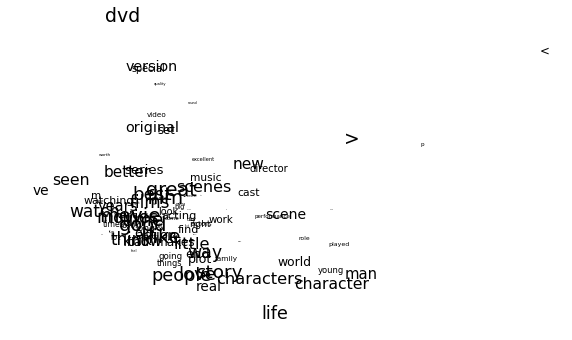

In [ ]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(helpfulreducedPCA_data[:, 0], helpfulreducedPCA_data[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(helpfultargetWords):
    ax.annotate(word, (helpfulreducedPCA_data[:, 0][i],helpfulreducedPCA_data[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

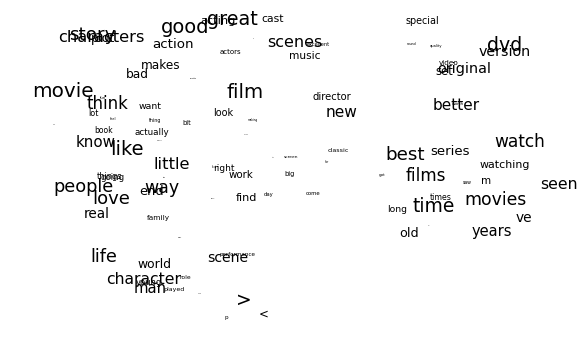

In [ ]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(helpfultsneWords[:, 0], helpfultsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(helpfultargetWords):
    ax.annotate(word, (helpfultsneWords[:, 0][i],helpfultsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

In [ ]:
unhelpfulW2V = gensim.models.word2vec.Word2Vec(unhelpful['normalized sents'].sum(), sg=0)

In [ ]:
unhelpfultargetWords = unhelpfulW2V.wv.index2word[:100]
unhelpfulwordsSubMatrix = []
for word in unhelpfultargetWords:
    unhelpfulwordsSubMatrix.append(unhelpfulW2V[word])
unhelpfulwordsSubMatrix = np.array(unhelpfulwordsSubMatrix)
unhelpfulwordsSubMatrix

array([[ 2.1103436e-01,  9.4251645e-01, -1.8792975e-01, ...,
         4.9647124e-04, -5.4364961e-01,  2.8726244e-01],
       [ 1.4436357e-01,  9.8650920e-01, -1.9597508e-01, ...,
         3.9887179e-02, -7.0373684e-01,  2.6876777e-01],
       [ 1.4116803e-01,  9.7024858e-01, -1.9276430e-01, ...,
         2.8447064e-02, -6.7200452e-01,  2.6338708e-01],
       ...,
       [ 1.5102695e-01,  1.1111448e+00, -2.2588111e-01, ...,
         4.1009411e-02, -8.3149832e-01,  2.9463521e-01],
       [ 1.4707625e-01,  9.0121734e-01, -1.8429476e-01, ...,
         4.2314943e-02, -6.1207855e-01,  2.3244394e-01],
       [ 1.3824387e-01,  9.7723138e-01, -1.9256973e-01, ...,
         3.4055647e-02, -7.0714062e-01,  2.5791964e-01]], dtype=float32)

In [ ]:
numWords = 100

In [ ]:
unhelpfulpcaWords = sklearn.decomposition.PCA(n_components = numWords).fit(unhelpfulwordsSubMatrix)
unhelpfulreducedPCA_data = helpfulpcaWords.transform(unhelpfulwordsSubMatrix)
unhelpfultsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(unhelpfulreducedPCA_data)

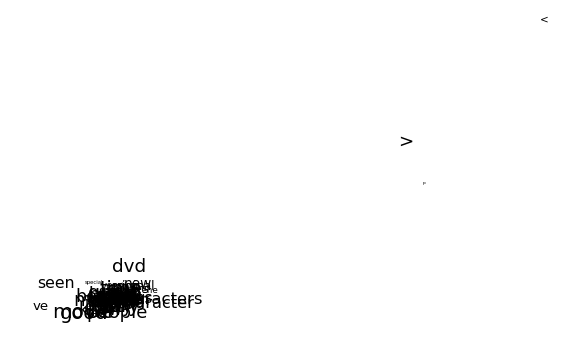

In [ ]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(unhelpfulreducedPCA_data[:, 0], unhelpfulreducedPCA_data[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(unhelpfultargetWords):
    ax.annotate(word, (unhelpfulreducedPCA_data[:, 0][i],unhelpfulreducedPCA_data[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

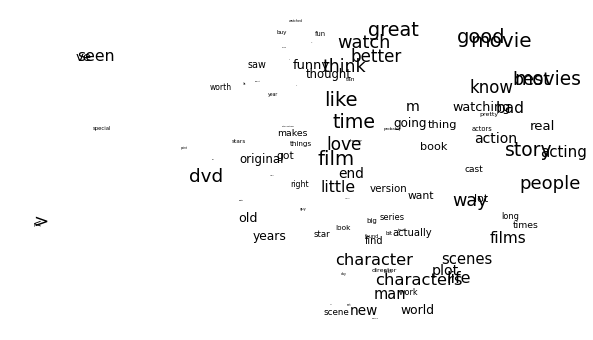

In [ ]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(unhelpfultsneWords[:, 0], unhelpfultsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(unhelpfultargetWords):
    ax.annotate(word, (unhelpfultsneWords[:, 0][i],unhelpfultsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

# Prediction and Causal Inference

Below I run OLS regression to answer the research question: what makes helpful(unhelpful) movie reviews helpful(unhelpful)? I will only look at reviews with helpfulness score available.

In [ ]:
sample_available = df.dropna()

In [ ]:
sample_available['length'] = sample_available['text'].apply(lambda x: len(sample_available['text']))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
y = sample_available['helpfulness']
X_cols = ['year']
X = sm.add_constant(sample_available[X_cols])

lm2 = sm.OLS(y,X).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            helpfulness   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                 4.572e+04
Date:                Mon, 14 Mar 2022   Prob (F-statistic):               0.00
Time:                        16:11:37   Log-Likelihood:            -2.4200e+06
No. Observations:             5919958   AIC:                         4.840e+06
Df Residuals:                 5919956   BIC:                         4.840e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.0490      0.086    221.118      0.000      18.880      19.218
year          -0.0092   4.29e-05   -213.814      0.000      -0.009      -0.009
==============================================================================
Omnibus:                  1487870.706   Durbin-Watson:                   0.302
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           480855.286
Skew:                          -0.494   Prob(JB):                         0.00
Kurtosis:                       2.013   Cond. No.                     1.15e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.15e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
y = sample_available['score']
X_cols = ['year']
X = sm.add_constant(sample_available[X_cols])

lm2 = sm.OLS(y,X).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                 2.179e+04
Date:                Mon, 14 Mar 2022   Prob (F-statistic):               0.00
Time:                        16:11:40   Log-Likelihood:            -1.0134e+07
No. Observations:             5919958   AIC:                         2.027e+07
Df Residuals:                 5919956   BIC:                         2.027e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.7798      0.317    160.161      0.000      50.158      51.401
year          -0.0233      0.000   -147.625      0.000      -0.024      -0.023
==============================================================================
Omnibus:                   811568.165   Durbin-Watson:                   1.111
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1203658.354
Skew:                          -1.104   Prob(JB):                         0.00
Kurtosis:                       2.925   Cond. No.                     1.15e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.15e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
y = sample_available['length']
X_cols = ['year']
X = sm.add_constant(sample_available[X_cols])

lm2 = sm.OLS(y,X).fit()
lm2.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 length   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                -5.920e+06
Date:                Mon, 14 Mar 2022   Prob (F-statistic):               1.00
Time:                        16:11:44   Log-Likelihood:             6.9116e+07
No. Observations:             5919958   AIC:                        -1.382e+08
Df Residuals:                 5919956   BIC:                        -1.382e+08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        5.92e+06   4.87e-07   1.22e+13      0.000    5.92e+06    5.92e+06
year        2.011e-10   2.43e-10      0.829      0.407   -2.74e-10    6.77e-10
==============================================================================
Omnibus:                  5941022.336   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           487865.990
Skew:                           0.358   Prob(JB):                         0.00
Kurtosis:                       1.789   Cond. No.                     1.15e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.15e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

It looks like both helpfulness of reviews and scores decreased overtime.

In [ ]:
y = sample_available['helpfulness']
X_cols = ['score','length','year']
X = sm.add_constant(sample_available[X_cols])

lm2 = sm.OLS(y,X).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            helpfulness   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                 2.546e+05
Date:                Mon, 14 Mar 2022   Prob (F-statistic):               0.00
Time:                        16:15:59   Log-Likelihood:            -2.1986e+06
No. Observations:             5919958   AIC:                         4.397e+06
Df Residuals:                 5919955   BIC:                         4.397e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
score          0.0729      0.000    678.110      0.000       0.073       0.073
length      2.592e-06    1.4e-08    184.509      0.000    2.56e-06    2.62e-06
year          -0.0075   4.14e-05   -180.487      0.000      -0.008      -0.007
==============================================================================
Omnibus:                   499687.339   Durbin-Watson:                   0.379
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           443921.591
Skew:                          -0.599   Prob(JB):                         0.00
Kurtosis:                       2.396   Cond. No.                     4.42e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.42e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Rating score has a significant positive effect on helpfulness score after controling for text length and year.

I was expecting that longer reviews are more likely to have high helpful score. However, the correlation seems rather low: you will need to write 10^5 more words to raise helpfulness score by ~0.26. Maybe length is not what matters - let's look at more specific information: I calculated the frequencies of two types of words: movie-related (including character, story, scene, plot, etc.) and sentiment (e.g. like, dislike, love, hate, good, bad, etc.) by dividing the count of words by length of the text.

In [ ]:
sample_available['frequency_movie'] = sample_available['text'].apply(lambda x: (x.count('character') + x.count('story') + x.count('scene') + x.count('plot') +x.count('director') + x.count('cast')+ x.count('acting'))/len(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
sample_available['frequency_sentiment'] = sample_available['text'].apply(lambda x: (x.count('like') + x.count('love') + x.count('hate') + x.count('dislike') +x.count('good') + x.count('bad')+ x.count('best')+ x.count('worst')+ x.count('interesting')+ x.count('boring')+ x.count('funny')+ x.count('terrible'))/len(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
y = sample_available['helpfulness']
X_cols = ['score','frequency_movie','frequency_sentiment']
X = sm.add_constant(sample_available[X_cols])

lm2 = sm.OLS(y,X).fit()
lm2.summary()

Interesting, the coefficient for requency_movie is not significant, but the frequency_sentiment is negatively correlated with helpfulness. However, the condition number is large, which may indicate strong multicollinearity.

In [ ]:
y = sample_available['helpfulness']
X_cols = ['frequency_movie','frequency_sentiment']
X = sm.add_constant(sample_available[X_cols])

lm2 = sm.OLS(y,X).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            helpfulness   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     44.18
Date:                Mon, 14 Mar 2022   Prob (F-statistic):           8.47e-20
Time:                        16:23:34   Log-Likelihood:                -2983.9
No. Observations:                7442   AIC:                             5974.
Df Residuals:                    7439   BIC:                             5994.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.6632      0.006    108.195      0.000       0.651       0.675
frequency_movie         0.8164      1.753      0.466      0.641      -2.619       4.252
frequency_sentiment   -11.0006      1.170     -9.399      0.000     -13.295      -8.706
==============================================================================
Omnibus:                     2872.792   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              709.297
Skew:                          -0.533   Prob(JB):                    9.51e-155
Kurtosis:                       1.927   Cond. No.                         419.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
y = sample_available['score']
X_cols = ['frequency_movie','frequency_sentiment']
X = sm.add_constant(sample_available[X_cols])

lm2 = sm.OLS(y,X).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     6.118
Date:                Mon, 14 Mar 2022   Prob (F-statistic):            0.00221
Time:                        02:08:29   Log-Likelihood:                -12817.
No. Observations:                7442   AIC:                         2.564e+04
Df Residuals:                    7439   BIC:                         2.566e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   4.0230      0.023    175.098      0.000       3.978       4.068
frequency_movie       -19.8999      6.569     -3.029      0.002     -32.777      -7.023
frequency_sentiment    -6.8735      4.387     -1.567      0.117     -15.473       1.726
==============================================================================
Omnibus:                     1029.046   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1524.328
Skew:                          -1.108   Prob(JB):                         0.00
Kurtosis:                       2.907   Cond. No.                         419.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

frequency_sentiment is not significantly correlated with score, but frequency_movie is. 

In [ ]:
sample_available['frequency_sentiment_pos'] = sample_available['text'].apply(lambda x: (x.count('like') + x.count('love') +x.count('good') + x.count('best')+ x.count('worst')+ x.count('interesting')+ x.count('funny'))/len(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
sample_available['frequency_sentiment_neg'] = sample_available['text'].apply(lambda x: (x.count('hate') + x.count('dislike') + x.count('bad')+ x.count('worst')+ x.count('boring')+ x.count('terrible'))/len(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
y = sample_available['score']
X_cols = ['frequency_movie','frequency_sentiment_pos','frequency_sentiment_neg']
X = sm.add_constant(sample_available[X_cols])

lm2 = sm.OLS(y,X).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     214.3
Date:                Mon, 14 Mar 2022   Prob (F-statistic):          2.32e-133
Time:                        02:57:45   Log-Likelihood:                -12515.
No. Observations:                7442   AIC:                         2.504e+04
Df Residuals:                    7438   BIC:                         2.507e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       4.0354      0.022    182.991      0.000       3.992       4.079
frequency_movie           -16.4920      6.309     -2.614      0.009     -28.859      -4.125
frequency_sentiment_pos    29.1372      4.470      6.519      0.000      20.375      37.899
frequency_sentiment_neg  -310.9097     12.646    -24.585      0.000    -335.700    -286.119
==============================================================================
Omnibus:                      934.493   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1334.137
Skew:                          -1.035   Prob(JB):                    1.98e-290
Kurtosis:                       3.145   Cond. No.                         839.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As expected, frequency_sentiment_pos is positively associated with score, and frequency_sentiment_neg is negatively associated.

In [ ]:
y = sample_available['helpfulness']
X_cols = ['frequency_movie','frequency_sentiment_pos','frequency_sentiment_neg']
X = sm.add_constant(sample_available[X_cols])

lm2 = sm.OLS(y,X).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            helpfulness   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     40.70
Date:                Mon, 14 Mar 2022   Prob (F-statistic):           4.41e-26
Time:                        02:51:21   Log-Likelihood:                -2967.2
No. Observations:                7442   AIC:                             5942.
Df Residuals:                    7438   BIC:                             5970.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.6636      0.006    108.545      0.000       0.652       0.676
frequency_movie             0.9919      1.749      0.567      0.571      -2.436       4.420
frequency_sentiment_pos    -8.5676      1.239     -6.914      0.000     -10.997      -6.139
frequency_sentiment_neg   -28.9637      3.506     -8.261      0.000     -35.836     -22.091
==============================================================================
Omnibus:                     2527.219   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              707.186
Skew:                          -0.544   Prob(JB):                    2.73e-154
Kurtosis:                       1.953   Cond. No.                         839.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

After splitting sentiment words into positive and negative ones, the coefficients are still siganificant and negative for both. frequency_sentiment_neg has larger negative effect than frequency_sentiment_pos.

## Mediation Model

The previous analysis show that reviews with higher frequency of words expressing sentiment have lower helpfulness score; reviews that rated the movie a higher score have higher helpfulness score. 

I would like to see whether rating itself affects helpfulness (rating -> helpfulness) or it affects helpfulness through the sentiment it demonstrate in the text of review (rating -> text sentiment -> helpfulness). In other words, are people giving upvotes based on the score the review gave? or based on the sentiment expressed in the text?

In [ ]:
sentiment = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [ ]:
sample_available['sentiment'] = sample_available['text'].apply(lambda x: sentiment(x[:512])[0]['score'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
sample_available['abs sentiment'] = sample_available['sentiment'].apply(lambda x: abs(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
# Mediation analysis
y = sample_available['sentiment']
X_cols = ['score']
X = sm.add_constant(sample_available[X_cols])
mediator_model = sm.OLS(y,X)

# For the second step of the mediation model, we can add in other predictors.
y = sample_available['helpfulness']
X_cols = ['score','sentiment','year']
X = sm.add_constant(sample_available[X_cols])
outcome_model = sm.OLS(y,X)

med = Mediation(outcome_model=outcome_model, mediator_model=mediator_model,
                exposure='score', mediator='sentiment').fit()
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),-0.000076,-0.000439,0.000234,0.594
ACME (treated),-0.000076,-0.000439,0.000234,0.594
ADE (control),0.072867,0.067152,0.078731,0.000
ADE (treated),0.072867,0.067152,0.078731,0.000
Total effect,0.072791,0.066948,0.078693,0.000
Prop. mediated (control),-0.000659,-0.006031,0.003137,0.594
Prop. mediated (treated),-0.000659,-0.006031,0.003137,0.594
ACME (average),-0.000076,-0.000439,0.000234,0.594
ADE (average),0.072867,0.067152,0.078731,0.000
Prop. mediated (average),-0.000659,-0.006031,0.003137,0.594


In [ ]:
# Mediation analysis
y = sample_available['abs sentiment']
X_cols = ['score']
X = sm.add_constant(sample_available[X_cols])
mediator_model = sm.OLS(y,X)

# For the second step of the mediation model, we can add in other predictors.
y = sample_available['helpfulness']
X_cols = ['score','abs sentiment','year']
X = sm.add_constant(sample_available[X_cols])
outcome_model = sm.OLS(y,X)

med = Mediation(outcome_model=outcome_model, mediator_model=mediator_model,
                exposure='score', mediator='abs sentiment').fit()
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),-0.000083,-0.000466,0.000219,0.578
ACME (treated),-0.000083,-0.000466,0.000219,0.578
ADE (control),0.073055,0.067107,0.079091,0.000
ADE (treated),0.073055,0.067107,0.079091,0.000
Total effect,0.072972,0.066984,0.078903,0.000
Prop. mediated (control),-0.000719,-0.006335,0.003077,0.578
Prop. mediated (treated),-0.000719,-0.006335,0.003077,0.578
ACME (average),-0.000083,-0.000466,0.000219,0.578
ADE (average),0.073055,0.067107,0.079091,0.000
Prop. mediated (average),-0.000719,-0.006335,0.003077,0.578


For both sentiment (positive-negative) and absolute value of sentiment, ACME is not significantly different from zero, but ADE is, which means the causal relationship is more likely rating -> helpfulness.

## Causal-Attribution

Below I will use the method proposed by [Pryzant et al. (2018)](https://nlp.stanford.edu/pubs/pryzant2018lexicon.pdf) to see how the use of a set of words affect helpfulness of reviews, after controlling for product ID. Unfortunately, since I'm using the sample of 10,000 reviews for this task, there are not enough data that allows for controlling user ID.

In [ ]:
!pip install causal-attribution

In [ ]:
import causal_attribution

In [ ]:
importance_scores = causal_attribution.score_vocab(
    vocab=[
           'good','great','bad','terrible','like','love','enjoy','hate', 'funny',
           'interesting','fun','boring', 'best', 'worst', 'recommend', 'dislike',
           'character', 'plot', 'story', 'scene', 'acting', 'effect', 'cast', 'director',
           # also check some common movie genres
           'action', 'horror', 'comedy', 'drama','crime', 'romance', 'gun', 'fiction', 'mystery', 'thriller',
           # below are some words that I was not expecting to affect helpfulness
           'she','her','he','him','they','them','husband','wife', 'family'
          ],
    csv='/Users/jiayukang/SOCI40133 Final Project/moviereview_sample.csv',
    delimiter=",",
    name_to_type={
        'text': 'input',
        'productId': 'control',
        'helpfulness': 'predict',
    })

importance_scores['helpfulness']

defaultdict(list,
            {'N/A': [('effect', 0.04076299972257402),
              ('gun', 0.030651779445548755),
              ('cast', 0.028575269167049555),
              ('comedy', 0.026726519981821184),
              ('horror', 0.0237608739253119),
              ('scene', 0.022639763959887205),
              ('plot', 0.0186705880144018),
              ('UNK', 0.01608335916989745),
              ('director', 0.01583677981773235),
              ('mystery', 0.014941255952635402),
              ('family', 0.013734461874264525),
              ('enjoy', 0.013096765953378053),
              ('fiction', 0.012706323717793566),
              ('husband', 0.010629643560605473),
              ('she', 0.008415811690724695),
              ('like', 0.007683904030727717),
              ('interesting', 0.007185120201938844),
              ('wife', 0.00698521854747014),
              ('drama', 0.006174225655740884),
              ('him', 0.005663061946961534),
              ('story', 0.0054939676

Reviews that mentioned "effect", "scene", "cast", and "plot" are more likely to be rated as helpful. Intuitively, the mentions of words related to specific details of movies make sense, but it's unexpected to see "husband" and "family" having a positive score here (they are lower than "UNK", though).

In terms of movie genres, reviews that mentioned "gun", "comedy", and "horror" are more likely to be rated as helpful, while mentions of "romance" would more likely less to lower helpfulness score.

Mentions of "hate", "dislike", "worst", "boring" will likely leading to low helpfulness - this corresponds with the previous finding that reviews that gave movies higher scores are more likely to be voted as helpful.

# Text Generation

Finally, I would like to explore what the corpus can tell us about movies. I will use GPT2 to generate text to see how the model trained on the movie review corpus is different from an untrained model. Beside, I will also experiment with text generation using the helpful corpus and unhelpful corpus separately.

In [ ]:
from transformers import AutoModelWithLMHead, AutoTokenizer

tokenizer_gpt = AutoTokenizer.from_pretrained("gpt2")
model_gpt = AutoModelWithLMHead.from_pretrained("gpt2")

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

In [ ]:
cd '/content/drive/MyDrive/SOCI40133 Final Project/'

/content/drive/MyDrive/SOCI40133 Final Project


In [ ]:
train_text, test_text = train_test_split(df['text'], test_size=0.2)
train_text.to_frame().to_csv(r'train_text_final', header=None, index=None, sep=' ', mode='a')
test_text.to_frame().to_csv(r'test_text_final', header=None, index=None, sep=' ', mode='a')

In [ ]:
pip install datasets

In [ ]:
pip install git+https://github.com/huggingface/transformers

In [ ]:
!python run_language_modeling.py --per_gpu_train_batch_size=1 --output_dir=output_gpt_moviereview --model_type=gpt2 --model_name_or_path=gpt2 --do_train --train_data_file=train_text_final --do_eval --eval_data_file=test_text_final

03/14/2022 03:23:24 - WARNING - __main__ - Process rank: -1, device: cuda:0, n_gpu: 1, distributed training: False, 16-bits training: False
03/14/2022 03:23:24 - INFO - __main__ - Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_steps=None,
evaluation_strategy=IntervalStrategy.NO,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_strategy=HubStrategy.EVERY_SAVE,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
label_n

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("output_gpt_moviereview")
model = AutoModelWithLMHead.from_pretrained("output_gpt_moviereview")

In [ ]:
sequence = "I love this movie because"

input = tokenizer.encode(sequence, return_tensors="pt")
generated = model.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer.decode(generated.tolist()[0])
print(resulting_string)

I love this movie because it is so funny and it is so funny.  I have watched it many times and I still love it.  I have watched it many times and I still love it.  I have watched it many times and I


In [ ]:
sequence = "I love this movie because"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

I love this movie because it's so much more than just a movie. It's a movie about a man who is a man who is a man who is a man who is a man who is a man who is a man who is a man


In [ ]:
sequence = "I recommend this movie because"

input = tokenizer.encode(sequence, return_tensors="pt")
generated = model.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer.decode(generated.tolist()[0])
print(resulting_string)

I recommend this movie because it is a great movie.  It is a great movie.  I have watched it many times and it is still one of my favorites.  I have watched it many times and it is still one of my favorites.


In [ ]:
sequence = "I recommend this movie because"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

I recommend this movie because it is so much more than just a movie. It is a story about a man who is forced to make a choice between his life and his family's. It is a story about a man who is forced to make a


In [ ]:
sequence = "This is the worst movie because the"

input = tokenizer.encode(sequence, return_tensors="pt")
generated = model.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer.decode(generated.tolist()[0])
print(resulting_string)

This is the worst movie because the acting is terrible.  The movie is so bad that it's hard to believe that it was made in the 80's.  The movie is so bad that it's hard to believe that it was made in the


In [ ]:
sequence = "This is the worst movie because the"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

This is the worst movie because the movie is so bad. It's so bad because it's so bad because it's so bad because it's so bad because it's so bad because it's so bad because it's so bad because it's so


In [ ]:
sequence = "The story of the movie is bad"

input = tokenizer.encode(sequence, return_tensors="pt")
generated = model.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer.decode(generated.tolist()[0])
print(resulting_string)

The story of the movie is bad, but it's still a good movie.  The acting is good, the story is good, and the special effects are good.  The movie is a good movie, but it's not a great movie.


In [ ]:
sequence = "The story of the movie is bad"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

The story of the movie is bad. It's not a good movie. It's not a good movie. It's not a good movie. It's not a good movie. It's not a good movie. It's not a good movie.


In [ ]:
sequence = "The best movie of the year is"

input = tokenizer.encode(sequence, return_tensors="pt")
generated = model.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer.decode(generated.tolist()[0])
print(resulting_string)

The best movie of the year is the one that I watched the first time I saw it.  It's a great movie, but it's not the best movie of the year.  It's not the best movie of the year either. 


In [ ]:
sequence = "The best movie of the year is"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

The best movie of the year is the one that's been nominated for three Oscars. It's a movie that's been nominated for three Oscars. It's a movie that's been nominated for three Oscars. It's a movie that's been nominated for


In [ ]:
sequence = "My favorite movie character is"

input = tokenizer.encode(sequence, return_tensors="pt")
generated = model.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer.decode(generated.tolist()[0])
print(resulting_string)

My favorite movie character is the one with the big smile on his face.  He is the one who is the one who is the one who is the one who is the one who is the one who is the one who is the one who is


In [ ]:
sequence = "My favorite movie character is"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

My favorite movie character is the one who is the most important person in the world. He is the one who is the most important person in the world. He is the one who is the most important person in the world. He is the one who


In [ ]:
sequence = "My favorite movie plot is"

input = tokenizer.encode(sequence, return_tensors="pt")
generated = model.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer.decode(generated.tolist()[0])
print(resulting_string)

My favorite movie plot is the one about the ""little girl"" who is a little girl who is a little girl's best friend.  The movie is about a girl who is a little girl's best friend who is a little girl's best friend


In [ ]:
sequence = "My favorite movie plot is"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

My favorite movie plot is the one where the protagonist is a young man who is trying to save his family from a group of evil aliens. The aliens are a group of aliens who are trying to destroy the planet Earth. The protagonist is a young man


In [ ]:
sequence = "My favorite movie scene is"

input = tokenizer.encode(sequence, return_tensors="pt")
generated = model.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer.decode(generated.tolist()[0])
print(resulting_string)

My favorite movie scene is when the two of them are in the car and the car is going to crash.  I think it was a great movie.  I would recommend it to anyone who likes to watch movies with a good story line."



In [ ]:
sequence = "My favorite movie scene is"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

My favorite movie scene is when the two of them are talking about the movie "The Matrix" and the two of them are talking about the movie "The Matrix Reloaded."

The movie "The Matrix Reloaded" is a movie about the Matrix and


While both models produce meaningful sentences, it looks like the model trained on movie reviews gives more information related to movies, and it's from the view of someone who have watched the movie (vs saying a movie is the best because it has been nominated for Oscar).

## helpful & unhelpful corpus
Now let's try models trained on helpful and unhelpful reviews.

In [ ]:
train_text_helpful, test_text_helpful = train_test_split(helpful['text'], test_size=0.2)
train_text_helpful.to_frame().to_csv(r'train_text_helpful', header=None, index=None, sep=' ', mode='a')
test_text_helpful.to_frame().to_csv(r'test_text_helpful', header=None, index=None, sep=' ', mode='a')

In [ ]:
!python run_language_modeling.py --per_gpu_train_batch_size=1 --output_dir=output_gpt_moviereview_ishelpful --model_type=gpt2 --model_name_or_path=gpt2 --do_train --train_data_file=train_text_helpful --do_eval --eval_data_file=test_text_helpful

03/14/2022 05:00:20 - WARNING - __main__ - Process rank: -1, device: cuda:0, n_gpu: 1, distributed training: False, 16-bits training: False
03/14/2022 05:00:20 - INFO - __main__ - Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_steps=None,
evaluation_strategy=IntervalStrategy.NO,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_strategy=HubStrategy.EVERY_SAVE,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
label_n

In [ ]:
tokenizer_helpful = AutoTokenizer.from_pretrained("output_gpt_moviereview_ishelpful")
model_helpful = AutoModelWithLMHead.from_pretrained("output_gpt_moviereview_ishelpful")

In [ ]:
train_text_unhelpful, test_text_unhelpful = train_test_split(unhelpful['text'], test_size=0.2)
train_text_unhelpful.to_frame().to_csv(r'train_text_unhelpful', header=None, index=None, sep=' ', mode='a')
test_text_unhelpful.to_frame().to_csv(r'test_text_unhelpful', header=None, index=None, sep=' ', mode='a')

In [ ]:
!python run_language_modeling.py --per_gpu_train_batch_size=1 --output_dir=output_gpt_moviereview_unhelpful --model_type=gpt2 --model_name_or_path=gpt2 --do_train --train_data_file=train_text_unhelpful --do_eval --eval_data_file=test_text_unhelpful

03/14/2022 05:41:09 - WARNING - __main__ - Process rank: -1, device: cuda:0, n_gpu: 1, distributed training: False, 16-bits training: False
03/14/2022 05:41:09 - INFO - __main__ - Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_steps=None,
evaluation_strategy=IntervalStrategy.NO,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_strategy=HubStrategy.EVERY_SAVE,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
label_n

In [ ]:
!python run_generation.py --model_type=gpt2 --model_name_or_path=output_gpt_moviereview_unhelpful

03/14/2022 05:58:32 - WARNING - __main__ - device: cuda, n_gpu: 1, 16-bits training: False
03/14/2022 05:58:37 - INFO - __main__ - Namespace(device=device(type='cuda'), fp16=False, k=0, length=20, model_name_or_path='output_gpt_moviereview_unhelpful', model_type='gpt2', n_gpu=1, no_cuda=False, num_return_sequences=1, p=0.9, padding_text='', prefix='', prompt='', repetition_penalty=1.0, seed=42, stop_token=None, temperature=1.0, xlm_language='')
Model prompt >>> 

In [ ]:
tokenizer_unhelpful = AutoTokenizer.from_pretrained("output_gpt_moviereview_unhelpful")
model_unhelpful = AutoModelWithLMHead.from_pretrained("output_gpt_moviereview_unhelpful")

In [ ]:
sequence = "I love this movie because"

input = tokenizer_helpful.encode(sequence, return_tensors="pt")
generated = model_helpful.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_helpful.decode(generated.tolist()[0])
print(resulting_string)

I love this movie because it's so funny and it's so funny.  I love the way the characters are portrayed and the way they are treated.  I love the way the characters are treated in the movie.  I love the way the


In [ ]:
sequence = "I love this movie because"

input = tokenizer_unhelpful.encode(sequence, return_tensors="pt")
generated = model_unhelpful.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_unhelpful.decode(generated.tolist()[0])
print(resulting_string)

I love this movie because it is so funny.  I love the way it is written.  I love the way it is written.  I love the way it is written.  I love the way it is written.  I love the


In [ ]:
sequence = "I recommend this movie because"

input = tokenizer_helpful.encode(sequence, return_tensors="pt")
generated = model_helpful.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_helpful.decode(generated.tolist()[0])
print(resulting_string)

I recommend this movie because it is a great movie.  It is a great movie.  It is a great movie.  It is a great movie.  It is a great movie.  It is a great movie.  It is a


In [ ]:
sequence = "I recommend this movie because"

input = tokenizer_unhelpful.encode(sequence, return_tensors="pt")
generated = model_unhelpful.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_unhelpful.decode(generated.tolist()[0])
print(resulting_string)

I recommend this movie because it is a great movie.  It is a great movie.  It is a great movie.  It is a great movie.  It is a great movie.  It is a great movie.  It is a


In [ ]:
sequence = "This is the worst movie because the"

input = tokenizer_helpful.encode(sequence, return_tensors="pt")
generated = model_helpful.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_helpful.decode(generated.tolist()[0])
print(resulting_string)

This is the worst movie because the acting is so bad.  The movie is so bad because the plot is so bad.  The plot is so bad because the characters are so bad.  The movie is so bad because the characters are so bad


In [ ]:
sequence = "This is the worst movie because the"

input = tokenizer_unhelpful.encode(sequence, return_tensors="pt")
generated = model_unhelpful.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_unhelpful.decode(generated.tolist()[0])
print(resulting_string)

This is the worst movie because the acting is so bad.  The movie is so bad because the actors are so bad.  The acting is so bad because the actors are so bad.  The movie is so bad because the actors are so bad


In [ ]:
sequence = "The story of the movie is bad"

input = tokenizer_helpful.encode(sequence, return_tensors="pt")
generated = model_helpful.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_helpful.decode(generated.tolist()[0])
print(resulting_string)

The story of the movie is bad, but it's not bad at all.  The acting is good, the story is good, and the acting is good.  The movie is a good movie, but it's not good at all. 


In [ ]:
sequence = "The story of the movie is bad"

input = tokenizer_unhelpful.encode(sequence, return_tensors="pt")
generated = model_unhelpful.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_unhelpful.decode(generated.tolist()[0])
print(resulting_string)

The story of the movie is bad, but it's still a good movie.  The acting is good, the story is good, and the acting is good.  The movie is a good movie, but it's still a good movie. 


In [ ]:
sequence = "The best movie of the year is"

input = tokenizer_helpful.encode(sequence, return_tensors="pt")
generated = model_helpful.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_helpful.decode(generated.tolist()[0])
print(resulting_string)

The best movie of the year is ""The Last Samurai"" by the same name.  It's a great movie, but it's not the best movie of the year.  It's not the best movie of the year, but it's not


In [ ]:
sequence = "The best movie of the year is"

input = tokenizer_unhelpful.encode(sequence, return_tensors="pt")
generated = model_unhelpful.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_unhelpful.decode(generated.tolist()[0])
print(resulting_string)

The best movie of the year is ""The Sixth Sense"" by the same name.  It's a great movie, but it's not a great movie.  It's a great movie, but it's not a great movie.  It's


In [ ]:
sequence = "My favorite movie character is"

input = tokenizer_helpful.encode(sequence, return_tensors="pt")
generated = model_helpful.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_helpful.decode(generated.tolist()[0])
print(resulting_string)

My favorite movie character is the one who is the most annoying.  He is the one who is the most annoying.  He is the one who is the most annoying.  He is the one who is the most annoying.  He is the


In [ ]:
sequence = "My favorite movie character is"

input = tokenizer_unhelpful.encode(sequence, return_tensors="pt")
generated = model_unhelpful.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_unhelpful.decode(generated.tolist()[0])
print(resulting_string)

My favorite movie character is the one who is the only one who can't stand the sight of a dead body.  He is the only one who can't stand the sight of a dead body.  He is the only one who can't stand


In [ ]:
sequence = "My favorite movie plot is"

input = tokenizer_helpful.encode(sequence, return_tensors="pt")
generated = model_helpful.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_helpful.decode(generated.tolist()[0])
print(resulting_string)

My favorite movie plot is the one about the ""little girl"" who is the only one who can remember her name.  She is a little girl who is a little girl who is a little girl who is a little girl who is a little girl


In [ ]:
sequence = "My favorite movie plot is"

input = tokenizer_unhelpful.encode(sequence, return_tensors="pt")
generated = model_unhelpful.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_unhelpful.decode(generated.tolist()[0])
print(resulting_string)

My favorite movie plot is the one about the two brothers who are trying to get back together.  The movie is a little slow, but it's still a good movie.  The plot is pretty good, and the characters are all pretty good.


In [ ]:
sequence = "My favorite movie scene is"

input = tokenizer_helpful.encode(sequence, return_tensors="pt")
generated = model_helpful.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_helpful.decode(generated.tolist()[0])
print(resulting_string)

My favorite movie scene is when the two of them are in the hospital.  The scene where they are in the hospital is one of the best I've ever seen.  It's a great scene and I'm sure it will be a favorite of


In [ ]:
sequence = "My favorite movie scene is"

input = tokenizer_unhelpful.encode(sequence, return_tensors="pt")
generated = model_unhelpful.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_unhelpful.decode(generated.tolist()[0])
print(resulting_string)

My favorite movie scene is when the two of them are in the middle of a fight.  I think it was a great scene.  I think it was a great movie.  I think it was a great movie.  I think it was


Interestingly, even unhelpful reviews can give meaningful and interesting answers!